In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks 
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP

plt.rcParams['figure.facecolor'] = 'white'

In [3]:
from loss.nll_loss import NLLRegLoss
from torch.nn import functional as F
from model.ensemble import MLPEnsemble

def nll_postprocessing(x):
    return torch.cat([x[:, [0]], F.softplus(x[:, [1]])], dim=1)

def nll_mean_only(x):
    return x[:, 0]

In [4]:
import torch
torch.cuda.set_device(1)

In [5]:

config = {
    'nn_runs': 200,
    'verbose': False,
    'use_cache': False, 
    'layers': [1, 128, 128, 64, 1],
    'nll_layers': [1, 128, 128, 64, 2],
    'patience': 10,
    'dropout_train': 0.2,
    'dropout_uq': 0.5
}

### Visualizing on toy data

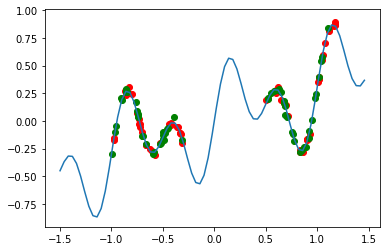

In [6]:
# Generate dataset
# dataset = 'qubic'
dataset = 'sin'
 
if dataset == 'qubic':
    x_train, y_train = ToyQubicData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToyQubicData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToyQubicData().dataset('ground_truth')
else:
    x_train, y_train = ToySinData(use_cache=config['use_cache']).dataset('train')
    x_val, y_val = ToySinData(use_cache=config['use_cache']).dataset('val')
    x_true, y_true = ToySinData().dataset('ground_truth')
    
plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')

In [7]:
models = {}

### RMSE

Epoch [100/10000], Loss: 0.0252, Validation loss: 0.0131
Epoch [200/10000], Loss: 0.0019, Validation loss: 0.0057
Epoch [300/10000], Loss: 0.0057, Validation loss: 0.0072
Epoch [400/10000], Loss: 0.0143, Validation loss: 0.0030
Epoch [500/10000], Loss: 0.0165, Validation loss: 0.0050
Epoch [600/10000], Loss: 0.0070, Validation loss: 0.0051
Epoch [700/10000], Loss: 0.0032, Validation loss: 0.0042
Epoch [800/10000], Loss: 0.0007, Validation loss: 0.0042
Epoch [900/10000], Loss: 0.0017, Validation loss: 0.0036
Epoch [1000/10000], Loss: 0.0007, Validation loss: 0.0060
Epoch [1100/10000], Loss: 0.0065, Validation loss: 0.0084
Epoch [1200/10000], Loss: 0.0006, Validation loss: 0.0030
Epoch [1300/10000], Loss: 0.0023, Validation loss: 0.0098
Epoch [1400/10000], Loss: 0.0023, Validation loss: 0.0064
Epoch [1500/10000], Loss: 0.0120, Validation loss: 0.0068
Epoch [1600/10000], Loss: 0.0019, Validation loss: 0.0072
Epoch [1700/10000], Loss: 0.0062, Validation loss: 0.0072
Epoch [1800/10000], Los

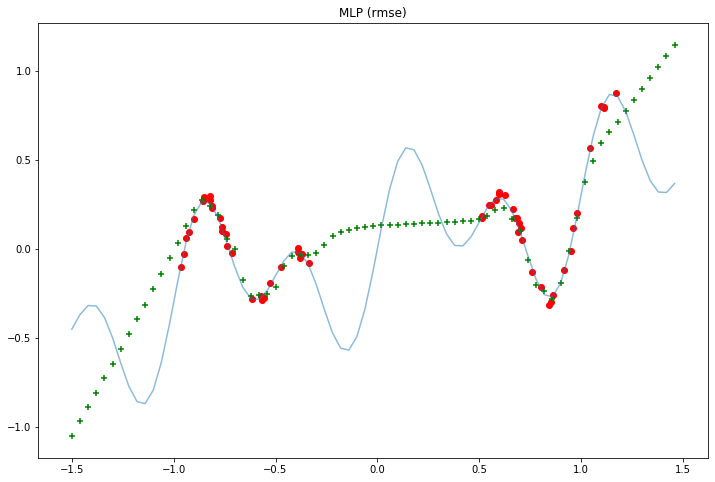

In [12]:
# Train model
models['mlp_rmse'] = MLP(config['layers'])
models['mlp_rmse'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['mlp_rmse'](x_true).cpu().numpy()

plt.figure(figsize=(12, 8))
plt.title('MLP (rmse)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

Fit [0/5] model:
Epoch [100/10000], Loss: 0.0174, Validation loss: 0.0135
Epoch [200/10000], Loss: 0.0114, Validation loss: 0.0059
Epoch [300/10000], Loss: 0.0028, Validation loss: 0.0043
Epoch [400/10000], Loss: 0.0190, Validation loss: 0.0041
Epoch [500/10000], Loss: 0.0038, Validation loss: 0.0052
Epoch [600/10000], Loss: 0.0062, Validation loss: 0.0043
Epoch [700/10000], Loss: 0.0017, Validation loss: 0.0043
Epoch [800/10000], Loss: 0.0050, Validation loss: 0.0079
Epoch [900/10000], Loss: 0.0195, Validation loss: 0.0060
Epoch [1000/10000], Loss: 0.0121, Validation loss: 0.0053
Epoch [1100/10000], Loss: 0.0009, Validation loss: 0.0055
Epoch [1200/10000], Loss: 0.0006, Validation loss: 0.0056
Epoch [1300/10000], Loss: 0.0028, Validation loss: 0.0050
Epoch [1400/10000], Loss: 0.0078, Validation loss: 0.0067
Fit [1/5] model:
Epoch [100/10000], Loss: 0.0048, Validation loss: 0.0125
Epoch [200/10000], Loss: 0.0114, Validation loss: 0.0056
Epoch [300/10000], Loss: 0.0172, Validation loss:

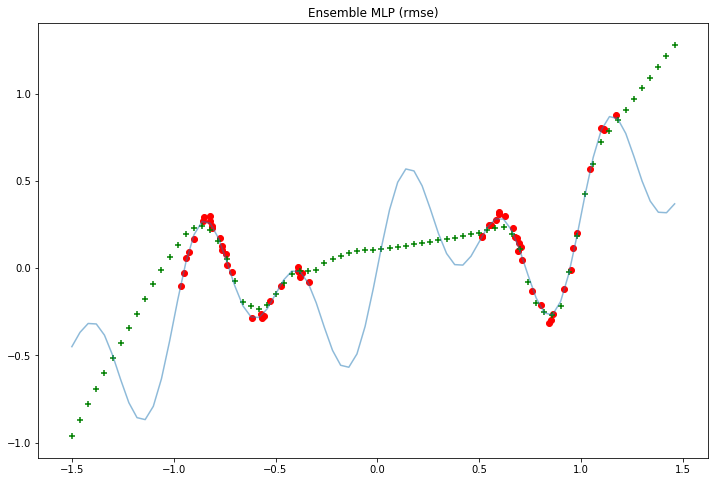

In [13]:
# Train model

models['ensemble_rmse'] = MLPEnsemble(config['layers'], n_models=5)
models['ensemble_rmse'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['ensemble_rmse'](x_true).cpu().numpy()

plt.figure(figsize=(12, 8))
plt.title('Ensemble MLP (rmse)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

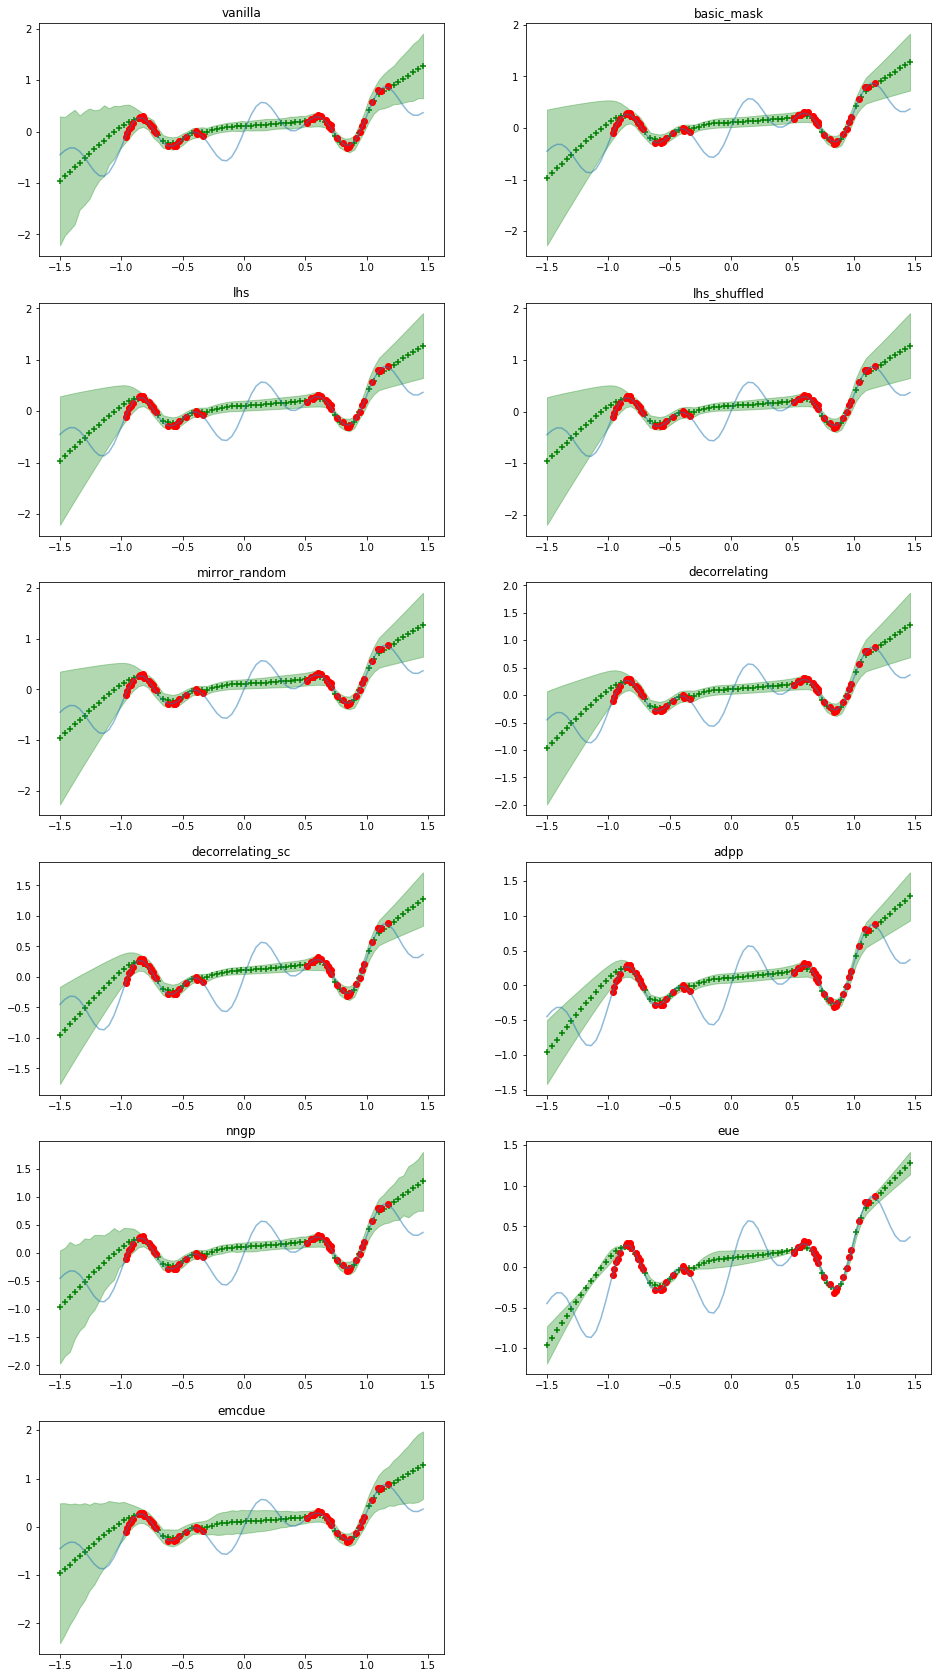

In [14]:
# Evaluate UQ and plot the results
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')

masks = build_masks(nn_runs = config['nn_runs'])
model = models['mlp_rmse']

for i, (name, mask) in enumerate(masks.items()):
    try:
        if hasattr(mask, 'reset'):
            mask.reset()
        estimator = build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])

        estimations = estimator.estimate(x_true)
        plt.subplot(6, 2, i+1)
        make_uq_graph(name, estimations)
    except:
        continue

        
nngp = build_estimator('nngp', model, nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = nngp.estimate(x_true, x_train)
plt.subplot(6, 2, len(masks)+1)
make_uq_graph('nngp', estimations)


eue = build_estimator('eue', models['ensemble_rmse'])
estimations = eue.estimate(x_true)
plt.subplot(6, 2, len(masks)+2)
make_uq_graph('eue', estimations)

eue = build_estimator('emcdue', models['ensemble_rmse'],
                      nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = eue.estimate(x_true)
plt.subplot(6, 2, len(masks)+3)
make_uq_graph('emcdue', estimations)

### NLL

Epoch [100/10000], Loss: -1.1925, Validation loss: -1.4508
Epoch [200/10000], Loss: -1.3578, Validation loss: -1.5821
Epoch [300/10000], Loss: -1.5013, Validation loss: -1.6604
Epoch [400/10000], Loss: -1.9842, Validation loss: -1.5975
Epoch [500/10000], Loss: -1.6284, Validation loss: -1.7583
Epoch [600/10000], Loss: -0.7463, Validation loss: -1.8020
Epoch [700/10000], Loss: -2.1270, Validation loss: -2.0091
Epoch [800/10000], Loss: -1.6033, Validation loss: -2.0875
Epoch [900/10000], Loss: -1.9060, Validation loss: -2.1394
Epoch [1000/10000], Loss: -2.0747, Validation loss: -2.0569
Epoch [1100/10000], Loss: -2.1443, Validation loss: -1.9519
Epoch [1200/10000], Loss: -1.9443, Validation loss: -2.0591
Epoch [1300/10000], Loss: -1.8225, Validation loss: -2.1753
Epoch [1400/10000], Loss: -1.8721, Validation loss: -2.2425
Epoch [1500/10000], Loss: -1.8318, Validation loss: -2.2081
Epoch [1600/10000], Loss: -1.4712, Validation loss: -2.0584
Epoch [1700/10000], Loss: -1.9745, Validation los

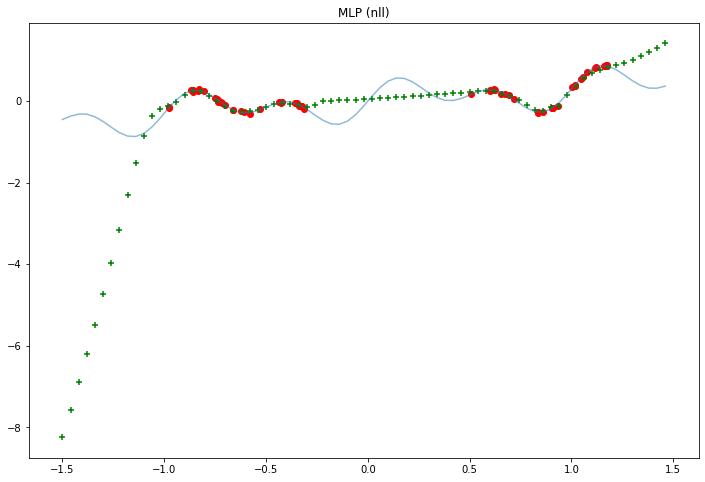

In [8]:
# Train model
models['mlp_nll'] = MLP(config['nll_layers'], loss=NLLRegLoss,
                        postprocessing=nll_postprocessing)
models['mlp_nll'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['mlp_nll'](x_true).cpu().numpy()[:, 0]

plt.figure(figsize=(12, 8))
plt.title('MLP (nll)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

Fit [0/5] model:
Epoch [100/10000], Loss: -1.1582, Validation loss: -1.3075
Epoch [200/10000], Loss: -0.9718, Validation loss: -1.3284
Epoch [300/10000], Loss: -1.2050, Validation loss: -1.9990
Epoch [400/10000], Loss: -1.2046, Validation loss: -1.7202
Epoch [500/10000], Loss: -1.9814, Validation loss: -1.8888
Epoch [600/10000], Loss: -1.4250, Validation loss: -1.8607
Epoch [700/10000], Loss: -1.9842, Validation loss: -1.9883
Epoch [800/10000], Loss: -2.0043, Validation loss: -2.2020
Epoch [900/10000], Loss: -0.8473, Validation loss: -2.0369
Epoch [1000/10000], Loss: -2.2535, Validation loss: -2.2734
Epoch [1100/10000], Loss: -2.0735, Validation loss: -1.9789
Epoch [1200/10000], Loss: -1.8495, Validation loss: -2.1039
Epoch [1300/10000], Loss: -1.8828, Validation loss: -2.2405
Epoch [1400/10000], Loss: -2.2150, Validation loss: -2.1394
Epoch [1500/10000], Loss: -1.6965, Validation loss: -2.2216
Epoch [1600/10000], Loss: -2.5181, Validation loss: -2.2821
Epoch [1700/10000], Loss: -1.849

Epoch [4100/10000], Loss: -0.3490, Validation loss: -2.4876
Epoch [4200/10000], Loss: -2.4543, Validation loss: -2.5314
Epoch [4300/10000], Loss: -1.9802, Validation loss: -2.1940
Fit [3/5] model:
Epoch [100/10000], Loss: -1.3179, Validation loss: -1.3653
Epoch [200/10000], Loss: -0.4896, Validation loss: -1.6349
Epoch [300/10000], Loss: -0.7028, Validation loss: -1.7911
Epoch [400/10000], Loss: -1.3395, Validation loss: -1.8651
Epoch [500/10000], Loss: -2.1384, Validation loss: -2.0207
Epoch [600/10000], Loss: -1.9613, Validation loss: -1.8663
Epoch [700/10000], Loss: -1.2208, Validation loss: -1.7542
Epoch [800/10000], Loss: -1.5953, Validation loss: -1.7661
Epoch [900/10000], Loss: -1.5743, Validation loss: -2.0287
Epoch [1000/10000], Loss: -1.2409, Validation loss: -1.9565
Epoch [1100/10000], Loss: -1.7557, Validation loss: -2.2717
Epoch [1200/10000], Loss: 0.2517, Validation loss: -2.1413
Epoch [1300/10000], Loss: -2.2922, Validation loss: -2.2083
Epoch [1400/10000], Loss: -1.8377

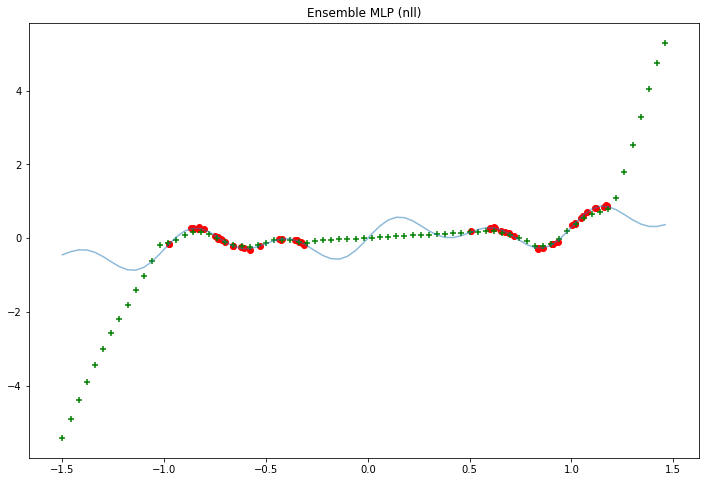

In [9]:
# Train model

models['ensemble_nll'] = MLPEnsemble(config['nll_layers'], n_models=5,
                    loss=NLLRegLoss, postprocessing=nll_postprocessing )
models['ensemble_nll'].fit((x_train, y_train), (x_train, y_train), patience=config['patience'],
          validation_step=100, batch_size=5, dropout_rate=config['dropout_train'])
y_pred = models['ensemble_nll'](x_true).cpu().numpy()[:, 0]

plt.figure(figsize=(12, 8))
plt.title('Ensemble MLP (nll)')
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_true, y_pred, color='green', marker='+')
plt.show()

In [10]:
models['mlp_nll'].postprocessing = nll_mean_only
for m in models['ensemble_nll'].models:
    m.postprocessing = nll_mean_only

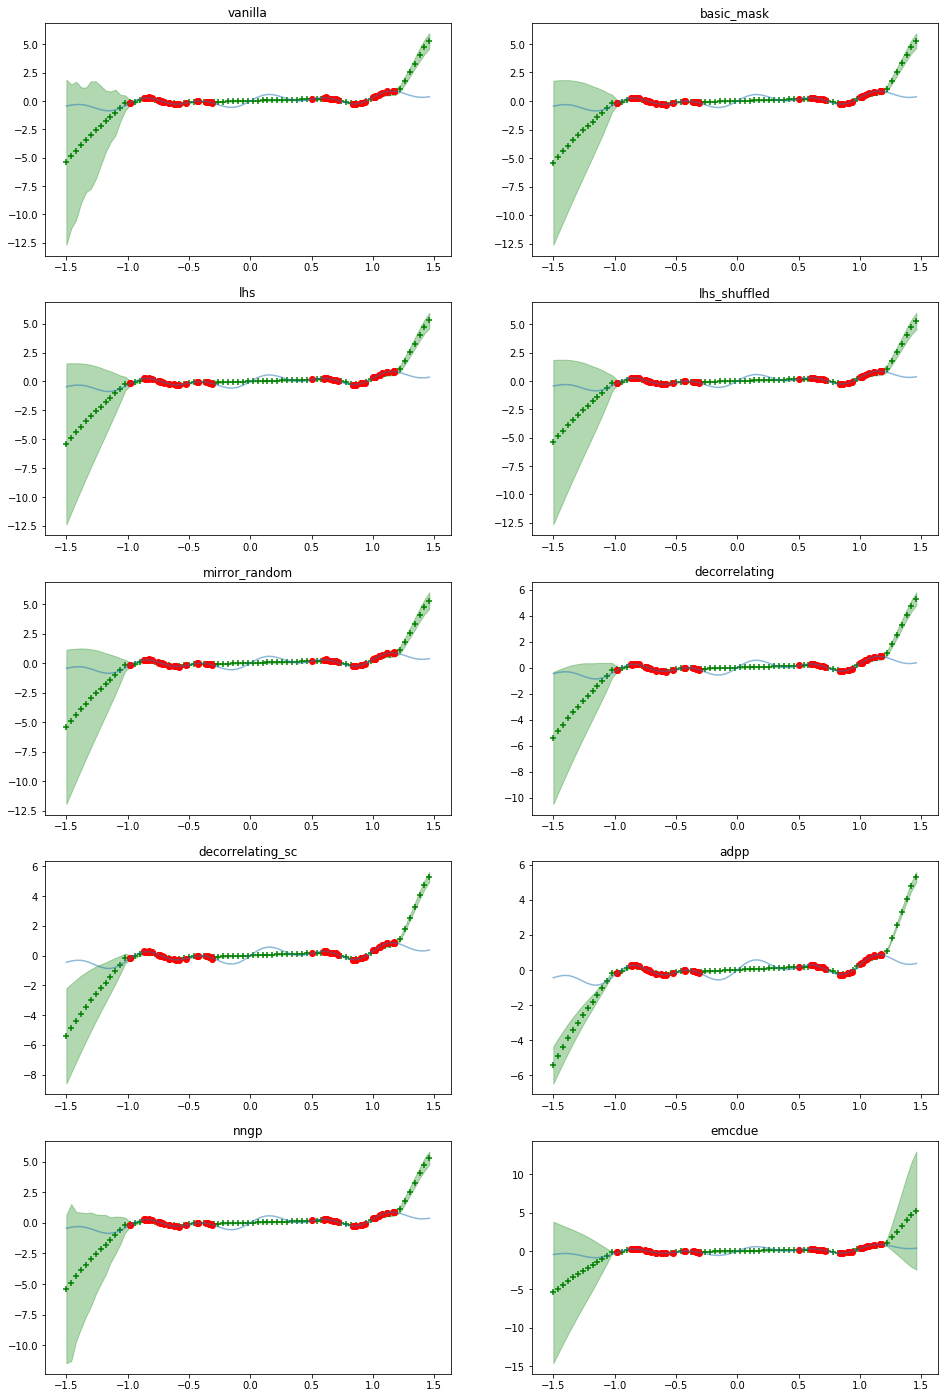

In [11]:
# Evaluate UQ and plot the results
plt.figure(figsize=(16, 30))

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred)-estimations, np.ravel(y_pred)+estimations, alpha=0.3, color='green')
    plt.scatter(x_train, y_train, color='red')

masks = build_masks(nn_runs = config['nn_runs'])
model = models['mlp_nll']

for i, (name, mask) in enumerate(masks.items()):
    try:
        if hasattr(mask, 'reset'):
            mask.reset()
        estimator = build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])

        estimations = estimator.estimate(x_true)
        plt.subplot(6, 2, i+1)
        make_uq_graph(name, estimations)
    except:
        continue

        
nngp = build_estimator('nngp', model, nn_runs=config['nn_runs'], dropout_rate=config['dropout_uq'])
estimations = nngp.estimate(x_true, x_train)
plt.subplot(6, 2, len(masks)+1)
make_uq_graph('nngp', estimations)


eue = build_estimator('eue', models['ensemble_nll'])
estimations = eue.estimate(x_true)
plt.subplot(6, 2, len(masks)+2)
make_uq_graph('emcdue', estimations)